
## Reconnaissance de commandes audio par programmation dynamique (DTW)


- Partie I : DTW (algorithme de programmation dynamique)
- Partie II : Système de reconnaissance audio de mots de commande
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

  On testera le système de reconnaissance audio sur deux corpus de voix qui serviront respectivement de base d'apprentissage (références) et de base de test (sons à reconnaître) qu'on choisira.
  La liste des 13 commandes au drone sont : *Atterrissage, Décollage, Avance, Tourne droite, Recule, Tourne gauche, Droite, Fais un flip, Gauche, Arrête toi, plus haut, plus bas et Etat d'urgence.*

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import array, zeros, full, argmin, inf, ndim
import scipy
import sklearn
import math
import os 
from os import walk 
from sklearn.metrics import confusion_matrix


# Partie I : DTW, calcul et l'affichage de la matrice des coûts. 


In [3]:
def DTW(A,B,d) : 
    w0 = 1
    w1 = 1
    w2 = 1 
    n = len(A)
    m = len(B)
    g = np.zeros((n+1,m+1))
    c = np.zeros((n+1,m+1))  # la direction du minimum choisi  
    for j in range(1,m+1) :
        g[0,j] = inf 
        c[0,j] = inf 
    for i in range(1,n+1) : 
        g[i,0] = inf
        c[i,0] = inf             
        for j in range(1,m+1) : 
            l = [ (g[i-1,j]+ w0 *d(A[i-1],B[j-1])), (g[i-1,j-1]+w1*d(A[i-1],B[j-1])), (g[i,j-1]+w2*d(A[i-1],B[j-1]))]
            g[i,j] = min(l)
            if (g[i-1,j-1]+w1*d(A[i-1],B[j-1])) == min(l) : 
                c[i,j] = 1
            else :    
                c[i,j] = l.index(min(l))   
    
    i=n
    j=m
    chemin = []
    while ((i!= 1) & (j !=1)) :      
        chemin.append((A[i-1],B[j-1]))
        if c[i,j] == 0 : 
            i = i-1
        elif c[i,j] == 2: 
            j = j-1
        else :
            i = i-1
            j=j-1
            
    chemin.append((A[0],B[0]))        
    score = g[n,m]/(n+m)
    return score

### Test du programme 

In [26]:
def d(a,b) : 
    return abs(a-b)

A = [2,1,-1,0] 
B = [-1,0,1,2,1] 

res = DTW(A,B,d)   
print(res)


0.8888888888888888


# Partie II :  Système de reconnaissance audio de mots de commande

La base des données contient des enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05).

On peut diviser ainsi l'ensemble des données en base d'apprentissage qui serviront de références et base de test pour évaluer la reconnaissance par programmation dynamique.

In [4]:
import librosa

Nous allons transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel de signal audio.

La matrice de sortie est composée d'autant de vecteurs colonnes que de trames d'analyses. Le nombre de lignes correspond à la dimension du vecteur représentatif : ici 12.

**Calcul des MFCC**

In [5]:

# charger les données de la base d'apprentissage et de test 
path_app = './App3'
path_test = './Test5'

#charger des données de la base d'apprentissage 
liste_app = os.listdir(path_app);
print(liste_app);
files_app = [path_app + '/' + e for e in liste_app];
label_app = [(e.split('_')[1]).split('.')[0]  for e in liste_app];

#charger les données de la base de test 
liste_test = os.listdir(path_test); 
files_test = [path_test + '/' + e for e in liste_test];
label_test = [(e.split('_')[1]).split('.')[0] for e in liste_test];


['F01_arretetoi.wav', 'F01_atterrissage.wav', 'F01_droite.wav', 'F01_etatdurgence.wav', 'F01_gauche.wav', 'F01_tournedroite.wav', 'F01_tournegauche.wav', 'F02_recule.wav', 'F03_decollage.wav', 'F03_droite.wav', 'F03_gauche.wav', 'F03_plusbas.wav', 'F03_plushaut.wav', 'F06_arretetoi.wav', 'F06_atterrissage.wav', 'F06_avance.wav', 'F06_decollage.wav', 'F06_droite.wav', 'F06_etatdurgence.wav', 'F06_faisunflip.wav', 'F06_gauche.wav', 'F06_plusbas.wav', 'F06_plushaut.wav', 'F06_recule.wav', 'F06_tournedroite.wav', 'F06_tournegauche.wav', 'M04_arretetoi.wav', 'M04_atterrissage.wav', 'M04_etatdurgence.wav', 'M04_gauche.wav', 'M04_plusbas.wav', 'M04_plushaut.wav', 'M04_tournedroite.wav', 'M04_tournegauche.wav', 'M05_atterrissage.wav', 'M05_avance.wav', 'M05_etatdurgence.wav', 'M05_plushaut.wav', 'M05_recule.wav', 'M05_tournedroite.wav', 'M05_tournegauche.wav', 'M06_decollage.wav', 'M06_droite.wav', 'M06_gauche.wav', 'M07_arretetoi.wav', 'M07_avance.wav', 'M07_plusbas.wav', 'M07_recule.wav', 'M

**Application de la DTW sur le corpus**

**Paramètres pour enregistrements audio des voix perso:**

16 KHz, mono, 16 bits, format *.wav*

In [6]:
def distance(a,b) : # distance euclidienne entre 2 vecteurs de taille 12 
    return np.linalg.norm(a-b)

label_pred_dtw = []; 
files_pred_dtw = []; 

for test in files_test :   
    y_test, sr_test = librosa.load(test); 
    mfcc_test = librosa.feature.mfcc(y=y_test, sr=sr_test, hop_length=1024, htk=True, n_mfcc=12); 
    score = []; 
    for app in files_app : 
        y_app, sr_app = librosa.load(app); 
        mfcc_app = librosa.feature.mfcc(y=y_app, sr=sr_app, hop_length=1024, htk=True, n_mfcc=12); 
        score_app = DTW(np.transpose(mfcc_test), np.transpose(mfcc_app),distance); 
        score.append(score_app); 
    k = score.index(min(score));  
    label_pred_dtw.append(label_app[k]);  
    files_pred_dtw.append(liste_app[k]); 
print(label_test);
print(label_pred_dtw); 
print(files_pred_dtw);  #nom du fichier predit 

['atterrissage', 'decollage', 'droite', 'plushaut', 'tournegauche', 'arretetoi', 'avance', 'etatdurgence', 'plusbas', 'recule', 'tournedroite', 'arretetoi', 'atterrissage', 'avance', 'decollage', 'droite', 'etatdurgence', 'faisunflip', 'gauche', 'plusbas', 'plushaut', 'recule', 'tournedroite', 'tournegauche', 'plusbas', 'atterrissage', 'droite', 'gauche', 'plusbas', 'tournegauche', 'avance', 'decollage', 'plushaut', 'recule', 'arretetoi', 'droite', 'gauche', 'plushaut', 'arretetoi', 'atterrissage', 'avance', 'decollage', 'droite', 'etatdurgence', 'gauche', 'plusbas', 'plushaut', 'recule', 'tournedroite', 'tournegauche']
['gauche', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'decollage', 'droite', 'atterrissage', 'atterrissage', 'atterrissage', 'atterrissage', 'plusbas', 'atterrissage', 'tournedroite', 'tournegauche', 'atterr

**Evaluation de la reconnaissance**

1. Calcul de la matrice de confusion du système

2. Calcul du score de reconnaissance 

In [7]:

#calcul de la matrice de confuion avec la fonction confusion_matrix 
ordre = list(set(label_app)); 
#print(ordre); 

nbre_ordre = len(ordre);

conf_dtw = confusion_matrix(label_test, label_pred_dtw); 
#print(label_test); 
#print(label_pred_dtw);
print(conf_dtw);
score_recon_dtw = (sum(conf_dtw[i][i] for i in range(len(conf_dtw))))/len(label_test); 
print('score de reconnaissance : '); 
print(score_recon_dtw); 

#score par rapport au sexe détecté 
# Tester la correction des labels, le sexe de la voix  
index = 0; 
#print(len(files_pred_dtw));
#print(liste_test); 
#print(files_pred_dtw);
for i in range(0,len(label_test)-1) : 
    if label_test[i] == label_pred_dtw[i] and (liste_test[i][1] == files_pred_dtw[i][1]) : 
        index = index + 1;         
#print(index);   
score_sex = index/(sum(conf_dtw[i][i] for i in range(len(conf_dtw)))); 

print('score par rapport au sexe : '); 
print(score_sex); 


#score par rapport à chaque label 
score_label_dtw = []; 
for i in range(0,nbre_ordre) : 
    score_label_dtw.append((ordre[i],conf_dtw[i][i]/sum(conf_dtw[i]))); 
print(score_label_dtw);    

[[0 2 0 0 0 0 0 0 0 0 2 0 0]
 [0 2 0 0 0 1 0 1 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 2 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 2 0 1 0 0 0 0 0 0]
 [0 2 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 0 1 0 0 0 0 0 0]
 [0 3 0 0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 1 1 0 0 1]
 [0 3 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 3]]
score de reconnaissance : 
0.32
score par rapport au sexe : 
0.8125
[('droite', 0.0), ('faisunflip', 0.5), ('tournegauche', 0.5), ('plushaut', 0.5), ('recule', 0.4), ('gauche', 0.3333333333333333), ('avance', 0.0), ('tournedroite', 0.0), ('atterrissage', 0.2), ('decollage', 0.2), ('arretetoi', 0.25), ('plusbas', 0.3333333333333333), ('etatdurgence', 0.75)]


## Partie III : Comparaison de la programmation dynamique (DTW) avec une méthode de classification (k-ppv) après prétraitement des données (ACP)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

In [9]:
# moyenne d'une matrice par colonne 

def mean(A) : 
    n = 12; 
    Ei = np.zeros((n,1)); 
    m = len(A[0]);
    for i in range(n) : 
        for k in range(m) : 
            Ei[i,0] = Ei[i,0] + A[i,k]/m;
    return Ei;           

### Prétraitement par ACP

Réduction de la dimension des MFCC

1. Calcul du vecteur moyen de $R^{13}$ sur toutes les fenêtres de MFCC (chaque enregistrement sera représenté par un seul vecteur de 13 coefficients MFCC).

2. Calcul des 3 axes principaux de l'ACP (on extrait les 3 vecteurs propres ($X_1$, $X_2$, $X_3$), associés aux 3 plus grandes valeurs propres de la matrice de variance-covariance $\Sigma_{App}$. Ces vecteurs propres consitueront la nouvelle base de données.

3. Projection des données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.


88
(88, 12)
(12, 2)


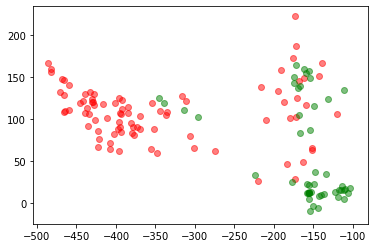

In [10]:
E = np.zeros((12, len(files_app))); 
i = 0
print(len(files_app));
for app in files_app : 
    y_app, sr_app = librosa.load(app); 
    mfcc_app = librosa.feature.mfcc(y=y_app, sr=sr_app, hop_length=1024, htk=True, n_mfcc=12);  
    E[:,i] = np.transpose(mean(mfcc_app));
    i = i+1; 
E = np.transpose(E);  
print(E.shape); 


#appliquer ACP 
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
pca.fit(E); 
P = np.transpose(pca.components_); 
print(P.shape); 


# trouver E_test 
E_test = np.zeros((12, len(files_test))); 
kk = 0
for test in files_test : 
    y_test, sr_test = librosa.load(test); 
    mfcc_test = librosa.feature.mfcc(y=y_test, sr=sr_test, hop_length=1024, htk=True, n_mfcc=12); 
    E_test[:,kk] = np.transpose(mean(mfcc_test));
    kk = kk+1; 
    
    
E_test = np.transpose(E_test);   


proj_test = E_test.dot(P); 

proj_app = E.dot(P); 

plt.scatter(proj_app[:,0], proj_app[:,1], c='r', alpha=0.5); 

plt.scatter(proj_test[:,0], proj_test[:,1], c='g', alpha=0.5); 


 


### Classification par $k$ plus proches voisins

On dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée $x$, la méthode des $k$ plus proches voisins consiste à prendre en compte (de façon identique) les $k$ échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle entrée $x$, selon une distance à définir. 

In [11]:
from sklearn.neighbors import KNeighborsClassifier


DataA = proj_app; 
labelA = label_app; 
neigh = KNeighborsClassifier(n_neighbors=1,metric='minkowski'); 
neigh.fit(DataA, labelA);  
KNeighborsClassifier(...)
label_pred_acp = []; 

for dataT in proj_test : 
    print(dataT); 
    label_pred_acp.append(neigh.predict([dataT])); 
    
print(label_pred_acp); 

    


[-111.45627898    5.49353836]
[-158.0310589    12.42230179]
[-157.35001879   12.15009584]
[-155.16338902   12.17022471]
[-155.45637813   12.83277895]
[-152.56154798   12.98061661]
[-155.94528331   11.74198473]
[-155.52459808   12.8854596 ]
[-140.84678293    9.74014158]
[-142.38946544    9.25877517]
[-136.94209887   10.77964899]
[-109.53360485   17.49044422]
[-105.60009776   12.03158869]
[-118.09878741   15.8005241 ]
[-134.13607745   35.20309062]
[-168.82344918  104.80310723]
[-103.71913545   18.50249951]
[-122.35000044   13.35676988]
[-118.75025224    7.91335465]
[-115.14318428   15.43834909]
[-167.43403043   83.72985209]
[-111.54461512   15.22354212]
[-153.91879988   86.86418126]
[-148.27940012   37.33173339]
[-113.54010426   21.06495348]
[-150.63124898   -3.10601172]
[-155.63796892    4.73538878]
[-154.17235281   -9.68271118]
[-223.96368398   33.9258083 ]
[-143.63328732   -5.71041177]
[-148.60607243   23.41823155]
[-155.93768506   21.18693666]
[-158.67936336   22.65859685]
[-177.1355

Evaluation de la méthode k-ppv

In [12]:
#matrice de confusion 
conf_acp = confusion_matrix(label_test, label_pred_acp); 
print(label_test); 
print(label_pred_acp);
print(conf_acp);
score_recon_acp = (sum(conf_acp[i][i] for i in range(len(conf_acp))))/len(label_test); 
print(score_recon_acp); 

#score par rapport à chaque label 
score_lab_acp = []; 
for i in range(0,nbre_ordre) : 
    score_lab_acp.append((ordre[i],conf_acp[i][i]/sum(conf_acp[i]))); 
print(score_lab_acp);    

['atterrissage', 'decollage', 'droite', 'plushaut', 'tournegauche', 'arretetoi', 'avance', 'etatdurgence', 'plusbas', 'recule', 'tournedroite', 'arretetoi', 'atterrissage', 'avance', 'decollage', 'droite', 'etatdurgence', 'faisunflip', 'gauche', 'plusbas', 'plushaut', 'recule', 'tournedroite', 'tournegauche', 'plusbas', 'atterrissage', 'droite', 'gauche', 'plusbas', 'tournegauche', 'avance', 'decollage', 'plushaut', 'recule', 'arretetoi', 'droite', 'gauche', 'plushaut', 'arretetoi', 'atterrissage', 'avance', 'decollage', 'droite', 'etatdurgence', 'gauche', 'plusbas', 'plushaut', 'recule', 'tournedroite', 'tournegauche']
[array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage'], dtype='<U12'), array(['atterrissage

Les résultats donnés par la programmation dynamique sont meilleurs.